In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
df_pop = pd.read_csv('datasets/population-past-future.csv')
df_pop = df_pop.dropna()
df_pop = df_pop[df_pop['Year'].between(1800,2021,inclusive ='both')]
df_pop

,Entity,Code,Year,Population (historical estimates and future projections)
37,Afghanistan,AFG,1800,3280000
38,Afghanistan,AFG,1801,3280000
39,Afghanistan,AFG,1802,3280000
40,Afghanistan,AFG,1803,3280000
41,Afghanistan,AFG,1804,3280000
...,...,...,...,...
74690,Zimbabwe,ZWE,2017,14236599
74691,Zimbabwe,ZWE,2018,14438812
74692,Zimbabwe,ZWE,2019,14645473
74693,Zimbabwe,ZWE,2020,14862927


In [27]:
#this block commented out as the dataset is too large to be uploaded, instead the processed dataset is used instead in the code block below

# df_dem = pd.read_csv('V-Dem-CY-Core-v12.csv')
# df_dem = df_dem[['country_name','country_text_id','year','v2x_polyarchy']]
# #df_dem.to_csv('df_dem.csv', encoding='utf-8',index=False)


In [3]:
df_dem = pd.read_csv('datasets/df_dem.csv')
df_dem

,country_name,country_text_id,year,v2x_polyarchy
0,Mexico,MEX,1789,0.026
1,Mexico,MEX,1790,0.026
2,Mexico,MEX,1791,0.026
3,Mexico,MEX,1792,0.026
4,Mexico,MEX,1793,0.026
...,...,...,...,...
27375,Piedmont-Sardinia,SPD,1857,0.214
27376,Piedmont-Sardinia,SPD,1858,0.213
27377,Piedmont-Sardinia,SPD,1859,0.213
27378,Piedmont-Sardinia,SPD,1860,0.215


In [4]:
df = pd.merge(df_pop, df_dem,  how='inner', left_on=['Code','Year'], right_on = ['country_text_id','year'])
df = df[['country_name', 'country_text_id', 'year', 'v2x_polyarchy','Population (historical estimates and future projections)']]
df.dropna(inplace = True)

In [5]:
df_gdp = pd.read_csv('datasets/gdp-per-capita-maddison-2020.csv')
df_gdp = df_gdp[['Entity','Code','Year','GDP per capita']]
df_gdp = df_gdp[df_gdp['Year'] >= 1800]
df_gdp.dropna(inplace = True)

In [6]:
def draw_brace(ax, xspan, yy, text):
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 500./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = -((1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1])))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, -y-.1*yspan, color='black', lw=1, clip_on=False)

    ax.text((xmax+xmin)/2., -yy+0.03*yspan, text, ha='center', va='bottom')

In [7]:
def main(pop):
    df = pd.merge(df_pop, df_dem,  how='inner', left_on=['Code','Year'], right_on = ['country_text_id','year'])
    df = df[['country_name', 'country_text_id', 'year', 'v2x_polyarchy','Population (historical estimates and future projections)']]
    df.dropna(inplace = True)
    df = pd.merge(df, df_gdp,  how='left', left_on=['country_text_id','year'], right_on = ['Code','Year'])
    df.drop(columns = ['Entity','Code','Year'],inplace = True)
    df.fillna(185,inplace = True)
    for i in range(0, df.shape[0]):
        if df.iloc[i]['GDP per capita'] == 185:
            if i == 0:
                pass
            elif df.iloc[i]['country_text_id'] == df.iloc[i-1]['country_text_id']:
                df.at[i,'GDP per capita']= df.iloc[i-1]['GDP per capita']
    df['GDP per capita'] = np.log10(df['GDP per capita'])
    df['times'] = round(df['Population (historical estimates and future projections)']/pop,0)
    df = df.loc[df.index.repeat(df.times)].reset_index(drop=True)
    df['interval'] = np.random.uniform(0,1,[df.shape[0]])
    for i in range(1800,2022):
        df_test = df[df['year']==i]
        ax = plt.scatter(x=df_test['v2x_polyarchy'], y = df_test['interval'], edgecolors='none', alpha=.60,c = df_test['GDP per capita'],cmap = 'winter',vmin=df['GDP per capita'].min(),vmax=df['GDP per capita'].max())
        ax.axes.get_yaxis().set_visible(False)
        cbar = plt.colorbar(ax)
        cbar.ax.set_ylabel('GDP per capita (USD)', rotation=270, labelpad=20,fontdict = {'fontsize': 12},ha='center',va='center')
        cbar_label = [2.47712212547,3,3.4771312547,4,4.477122547,5]
        cbar.set_ticks(cbar_label)
        cbar.set_ticklabels([int(10**i) for i in cbar_label])
        plt.axvline(x = 0.5, color = 'grey',alpha = 0.3,linestyle = '--')
        plt.gca().spines.top.set_visible(False)
        plt.xlim([0, 1])
        plt.ylim([-0.2,1.2])
        plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.25))
        plt.xlabel('Electoral Democracy Index',fontsize = '12')
        plt.title(f'How democratic are the governments \nthe global population live under?\n\n {i}\n\n', fontdict = {'fontsize' : 15},ha='center',va='center')
        plt.text(-0.1,-1,"* Each dot represents 200,000 people\n* Regime clasification is partly based on The Regimes of the World classification\n* Democracy Index is sourced from V-Dem (v12)'s Electoral democracy index (v2x_polyarchy)\n* GDP per capita of 185 means that there is no data available for that country that year \n  (185 taken as a pre-industrial revolution average according to Bairoch)\n* Electoral democracy index measures the principle of electoral or representative democracy,\n  including whether elections were free and fair,as well as the prevalence of a free and\n  independent media",size = 8)
        draw_brace(plt.gca(), (0, 0.5), -1.3, 'Autocracy')
        draw_brace(plt.gca(), (0.5, 1), -1.3, 'Democracy')
        plt.savefig(f'images-strip/{i}',facecolor='white', transparent=False,dpi = 144, bbox_inches="tight")
        plt.close()

In [8]:
# Uncomment below to call the main function and export the pages

#main(2000000) 


## Next two blocks are for testing and adjusting the figure

In [9]:
df = pd.merge(df_pop, df_dem,  how='inner', left_on=['Code','Year'], right_on = ['country_text_id','year'])
df = df[['country_name', 'country_text_id', 'year', 'v2x_polyarchy','Population (historical estimates and future projections)']]
df.dropna(inplace = True)
df = pd.merge(df, df_gdp,  how='left', left_on=['country_text_id','year'], right_on = ['Code','Year'])
df.drop(columns = ['Entity','Code','Year'],inplace = True)
df.fillna(185,inplace = True)
for i in range(0, df.shape[0]):
    if df.iloc[i]['GDP per capita'] == 185:
        if i == 0:
            pass
        elif df.iloc[i]['country_text_id'] == df.iloc[i-1]['country_text_id']:
            df.at[i,'GDP per capita']= df.iloc[i-1]['GDP per capita']
df['GDP per capita'] = np.log10(df['GDP per capita'])
df['times'] = round(df['Population (historical estimates and future projections)']/200000,0)
df = df.loc[df.index.repeat(df.times)].reset_index(drop=True)
df['interval'] = np.random.uniform(0,1,[df.shape[0]])

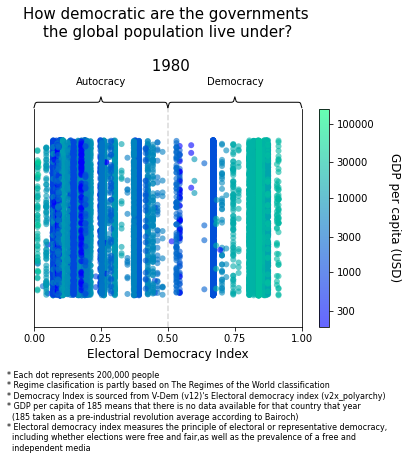

In [10]:
df_test = df[df['year']==1980]        
plt.figure()
ax = plt.scatter(x=df_test['v2x_polyarchy'], y = df_test['interval'], edgecolors='none', alpha=.60,c = df_test['GDP per capita'],cmap = 'winter',vmin=df['GDP per capita'].min(),vmax=df['GDP per capita'].max())
ax.axes.get_yaxis().set_visible(False)
cbar = plt.colorbar(ax)
cbar.ax.set_ylabel('GDP per capita (USD)', rotation=270, labelpad=20,fontdict = {'fontsize': 12},ha='center',va='center')
cbar_label = [2.47712212547,3,3.4771312547,4,4.477122547,5]
cbar.set_ticks(cbar_label)
cbar.set_ticklabels([int(10**i) for i in cbar_label])
plt.axvline(x = 0.5, color = 'grey',alpha = 0.3,linestyle = '--')
plt.xlim([0, 1])
plt.ylim([-0.2,1.2])
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.25))
plt.gca().spines.top.set_visible(False)
plt.xlabel('Electoral Democracy Index',fontsize = '12')
plt.text(-0.1,-1,"* Each dot represents 200,000 people\n* Regime clasification is partly based on The Regimes of the World classification\n* Democracy Index is sourced from V-Dem (v12)'s Electoral democracy index (v2x_polyarchy)\n* GDP per capita of 185 means that there is no data available for that country that year \n  (185 taken as a pre-industrial revolution average according to Bairoch)\n* Electoral democracy index measures the principle of electoral or representative democracy,\n  including whether elections were free and fair,as well as the prevalence of a free and\n  independent media",size = 8)
draw_brace(plt.gca(), (0, 0.5), -1.3, 'Autocracy')
draw_brace(plt.gca(), (0.5, 1), -1.3, 'Democracy')
plt.title(f'How democratic are the governments \nthe global population live under?\n\n 1980\n\n', fontdict = {'fontsize' : 15},ha='center',va='center')
plt.show()